##  Enosh Nyarige 
### Data Mining Final Project
#### Credit Card Fraud Detection

##### Jan - April 2021

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set_style("whitegrid")

## 1. Methods applied to acquire data

### Data related to this project was downloaded from Kaggle's respository, https://www.kaggle.com/mlg-ulb/creditcardfraud 

- Loading the downloaded dataset

In [6]:
!ls

creditCard_fraudDetection-Copy1.ipynb  dataset	README.md
creditCard_fraudDetection.ipynb        models


In [7]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

In [8]:
data = pd.read_csv("dataset/creditcard.csv")
data.head(2)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0


In [4]:
data.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')

- In this dataset, we can only use Time, Amount and Class columns. 

- The class feature is in the form of: 
    - 1: fraud
    - 0: not_fraud

- From the Class feature, the value counts for the two labels is 284315 and 492 for not_fraud and fraud respectively

In [10]:
data.Class.value_counts()

0    284315
1       492
Name: Class, dtype: int64

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

   ## 2. Data Pre-processing

- Convert the dataframe into two variables, 
    - Data features - V1 - V28
    - Label column - Class

In [11]:
def prep_data(data: pd.DataFrame) -> (np.ndarray, np.ndarray):

    X = data.iloc[:, 2:30].values
    y = data.Class.values
    return X, y

- Define a fucntion to create a scatter plot based on our data and labels

In [12]:
def plot_data(X: np.ndarray, y: np.ndarray):
    plt.scatter(X[y == 0, 0], X[y == 0, 1], label="Class #0", alpha=0.5, linewidth=0.15)
    plt.scatter(X[y == 1, 0], X[y == 1, 1], label="Class #1", alpha=0.5, linewidth=0.15, c='r')
    plt.legend()
    return plt.show()

- Initiate the X and y variables from the prep_data function
    - Plot our data by running the initiated data points

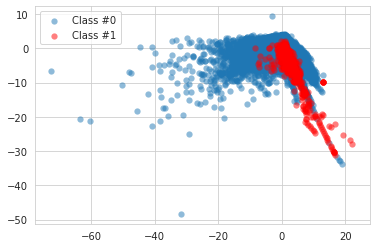

In [15]:
X, y = prep_data(data)
plot_data(X, y)

- From teh above distribution, we can clearly see that there is an imbalance between the two Classes of fraud
    - We will resample the training dataset using SMOTE from imblearn at the stage of splitting the data

   ## 3. Data scaling and transformation

In [16]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
np.random.seed(123)

- Split the dataset for training and testing

In [17]:
from imblearn.over_sampling import SMOTE

In [18]:
method = SMOTE()

X = data.iloc[:, 2:30]
y = data.Class  

X_validator, X_test, y_validator, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_train, X_validate, y_train, y_validate = train_test_split(X_validator, y_validator, test_size=0.2, random_state=42)

# Apply resampling to the training data only
X_resampled, y_resampled = method.fit_resample(X_train, y_train)

- We can compare the labels to see the distribution of data in each class

In [31]:
# The initial label values

pd.value_counts(pd.Series(y))

0    284315
1       492
Name: Class, dtype: int64

In [32]:
# The resampled label values

pd.value_counts(pd.Series(y_resampled))

0    159204
1    159204
Name: Class, dtype: int64

- Using Sklearn's StandardScaler, we can transform the dataset as well before we use it to build the model

In [19]:
scalar = StandardScaler()

X_train = scalar.fit_transform(X_train)
X_validate = scalar.transform(X_validate)
X_test = scalar.transform(X_test)

   ## 4. Model building

In [20]:
from tensorflow import keras

In [22]:
model = keras.Sequential([
    keras.layers.Dense(256, activation='relu', input_shape=(X_train.shape[-1],)),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(256, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(256, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(1, activation='sigmoid'),
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 256)               7424      
_________________________________________________________________
batch_normalization_3 (Batch (None, 256)               1024      
_________________________________________________________________
dropout_3 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 256)               65792     
_________________________________________________________________
batch_normalization_4 (Batch (None, 256)               1024      
_________________________________________________________________
dropout_4 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 256)              

## 5. Training of the model

In [23]:
print("\n")
print(f"Training Set: X_train: {X_train.shape}, y_train: {y_train.shape}\n\n{'*'*60}\n")
print(f"Validation Set: X_validate: {X_validate.shape}, y_validate: {y_validate.shape}\n\n{'*'*60}\n")
print(f"Testing Set: X_test: {X_test.shape}, y_test: {y_test.shape}")
print("\n")



Training Set: X_train: (159491, 28), y_train: (159491,)

************************************************************

Validation Set: X_validate: (39873, 28), y_validate: (39873,)

************************************************************

Testing Set: X_test: (85443, 28), y_test: (85443,)




In [24]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score

def print_score(label, prediction, train=True):
    if train:
        clf_report = pd.DataFrame(classification_report(label, prediction, output_dict=True))
        print("Train Result:\n================================================")
        print(f"Accuracy Score: {accuracy_score(label, prediction) * 100:.2f}%")
        print("_______________________________________________")
        print(f"Classification Report:\n{clf_report}")
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(y_train, prediction)}\n")
        
    elif train==False:
        clf_report = pd.DataFrame(classification_report(label, prediction, output_dict=True))
        print("Test Result:\n================================================")        
        print(f"Accuracy Score: {accuracy_score(label, prediction) * 100:.2f}%")
        print("_______________________________________________")
        print(f"Classification Report:\n{clf_report}")
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(label, prediction)}\n") 

In [25]:
METRICS = [
    keras.metrics.Accuracy(name='accuracy'),
    keras.metrics.FalseNegatives(name='fn'),
    keras.metrics.FalsePositives(name='fp'),
    keras.metrics.TrueNegatives(name='tn'),
    keras.metrics.TruePositives(name='tp'),
    keras.metrics.Precision(name='precision'),
    keras.metrics.Recall(name='recall')
]

model.compile(optimizer=keras.optimizers.Adam(1e-3), loss='binary_crossentropy', metrics=METRICS)

callbacks = [keras.callbacks.ModelCheckpoint('models/fraud_model.h5', save_best_only=True,monitor='val_loss', mode='min')]

r = model.fit(
    X_train, y_train, 
    validation_data=(X_validate, y_validate),
    batch_size=200, 
    epochs=50, 
    callbacks=callbacks,
)

Epoch 1/100
798/798 [==============================] - 5s 6ms/step - loss: 0.0854 - accuracy: 1.5675e-04 - fn: 117.0000 - fp: 4201.0000 - tn: 155003.0000 - tp: 170.0000 - precision: 0.0389 - recall: 0.5923 - val_loss: 0.0151 - val_accuracy: 0.0011 - val_fn: 14.0000 - val_fp: 14.0000 - val_tn: 39790.0000 - val_tp: 55.0000 - val_precision: 0.7971 - val_recall: 0.7971
Epoch 2/100
798/798 [==============================] - 4s 6ms/step - loss: 0.0080 - accuracy: 3.1350e-04 - fn: 99.0000 - fp: 55.0000 - tn: 159149.0000 - tp: 188.0000 - precision: 0.7737 - recall: 0.6551 - val_loss: 0.0076 - val_accuracy: 7.5239e-04 - val_fn: 14.0000 - val_fp: 12.0000 - val_tn: 39792.0000 - val_tp: 55.0000 - val_precision: 0.8209 - val_recall: 0.7971
Epoch 3/100
798/798 [==============================] - 6s 7ms/step - loss: 0.0060 - accuracy: 1.6302e-04 - fn: 101.0000 - fp: 42.0000 - tn: 159162.0000 - tp: 186.0000 - precision: 0.8158 - recall: 0.6481 - val_loss: 0.0060 - val_accuracy: 5.0159e-04 - val_fn: 14.

798/798 [==============================] - 6s 7ms/step - loss: 0.0018 - accuracy: 3.1350e-05 - fn: 59.0000 - fp: 18.0000 - tn: 159186.0000 - tp: 228.0000 - precision: 0.9268 - recall: 0.7944 - val_loss: 0.0047 - val_accuracy: 7.5239e-04 - val_fn: 14.0000 - val_fp: 10.0000 - val_tn: 39794.0000 - val_tp: 55.0000 - val_precision: 0.8462 - val_recall: 0.7971
Epoch 24/100
798/798 [==============================] - 6s 7ms/step - loss: 0.0019 - accuracy: 0.0000e+00 - fn: 56.0000 - fp: 21.0000 - tn: 159183.0000 - tp: 231.0000 - precision: 0.9167 - recall: 0.8049 - val_loss: 0.0043 - val_accuracy: 4.2635e-04 - val_fn: 13.0000 - val_fp: 6.0000 - val_tn: 39798.0000 - val_tp: 56.0000 - val_precision: 0.9032 - val_recall: 0.8116
Epoch 25/100
798/798 [==============================] - 5s 7ms/step - loss: 0.0019 - accuracy: 3.1350e-05 - fn: 56.0000 - fp: 22.0000 - tn: 159182.0000 - tp: 231.0000 - precision: 0.9130 - recall: 0.8049 - val_loss: 0.0045 - val_accuracy: 4.0127e-04 - val_fn: 12.0000 - val_

798/798 [==============================] - 6s 8ms/step - loss: 0.0011 - accuracy: 2.5080e-05 - fn: 39.0000 - fp: 16.0000 - tn: 159188.0000 - tp: 248.0000 - precision: 0.9394 - recall: 0.8641 - val_loss: 0.0050 - val_accuracy: 7.0223e-04 - val_fn: 19.0000 - val_fp: 6.0000 - val_tn: 39798.0000 - val_tp: 50.0000 - val_precision: 0.8929 - val_recall: 0.7246
Epoch 46/100
798/798 [==============================] - 6s 8ms/step - loss: 0.0013 - accuracy: 2.5080e-05 - fn: 41.0000 - fp: 17.0000 - tn: 159187.0000 - tp: 246.0000 - precision: 0.9354 - recall: 0.8571 - val_loss: 0.0051 - val_accuracy: 3.7619e-04 - val_fn: 13.0000 - val_fp: 6.0000 - val_tn: 39798.0000 - val_tp: 56.0000 - val_precision: 0.9032 - val_recall: 0.8116
Epoch 47/100
798/798 [==============================] - 6s 7ms/step - loss: 0.0011 - accuracy: 3.1350e-05 - fn: 36.0000 - fp: 15.0000 - tn: 159189.0000 - tp: 251.0000 - precision: 0.9436 - recall: 0.8746 - val_loss: 0.0052 - val_accuracy: 4.5143e-04 - val_fn: 13.0000 - val_f

798/798 [==============================] - 7s 9ms/step - loss: 8.2105e-04 - accuracy: 1.1913e-04 - fn: 29.0000 - fp: 19.0000 - tn: 159185.0000 - tp: 258.0000 - precision: 0.9314 - recall: 0.8990 - val_loss: 0.0058 - val_accuracy: 0.0013 - val_fn: 15.0000 - val_fp: 9.0000 - val_tn: 39795.0000 - val_tp: 54.0000 - val_precision: 0.8571 - val_recall: 0.7826
Epoch 68/100
798/798 [==============================] - 7s 9ms/step - loss: 8.8150e-04 - accuracy: 1.3794e-04 - fn: 27.0000 - fp: 15.0000 - tn: 159189.0000 - tp: 260.0000 - precision: 0.9455 - recall: 0.9059 - val_loss: 0.0057 - val_accuracy: 6.7715e-04 - val_fn: 13.0000 - val_fp: 9.0000 - val_tn: 39795.0000 - val_tp: 56.0000 - val_precision: 0.8615 - val_recall: 0.8116
Epoch 69/100
798/798 [==============================] - 7s 9ms/step - loss: 7.1044e-04 - accuracy: 7.5239e-05 - fn: 24.0000 - fp: 11.0000 - tn: 159193.0000 - tp: 263.0000 - precision: 0.9599 - recall: 0.9164 - val_loss: 0.0056 - val_accuracy: 7.7747e-04 - val_fn: 14.0000

798/798 [==============================] - 5s 6ms/step - loss: 6.8712e-04 - accuracy: 1.7556e-04 - fn: 22.0000 - fp: 13.0000 - tn: 159191.0000 - tp: 265.0000 - precision: 0.9532 - recall: 0.9233 - val_loss: 0.0061 - val_accuracy: 6.5207e-04 - val_fn: 14.0000 - val_fp: 11.0000 - val_tn: 39793.0000 - val_tp: 55.0000 - val_precision: 0.8333 - val_recall: 0.7971
Epoch 90/100
798/798 [==============================] - 5s 6ms/step - loss: 6.8205e-04 - accuracy: 6.8969e-05 - fn: 22.0000 - fp: 14.0000 - tn: 159190.0000 - tp: 265.0000 - precision: 0.9498 - recall: 0.9233 - val_loss: 0.0063 - val_accuracy: 7.5239e-04 - val_fn: 20.0000 - val_fp: 9.0000 - val_tn: 39795.0000 - val_tp: 49.0000 - val_precision: 0.8448 - val_recall: 0.7101
Epoch 91/100
798/798 [==============================] - 5s 6ms/step - loss: 6.1953e-04 - accuracy: 7.5239e-05 - fn: 27.0000 - fp: 14.0000 - tn: 159190.0000 - tp: 260.0000 - precision: 0.9489 - recall: 0.9059 - val_loss: 0.0066 - val_accuracy: 8.5271e-04 - val_fn: 13

## 8. Model Evaluation Techniques

- Get an overview of the test metrics performance

In [27]:
score = model.evaluate(X_test, y_test)
print(score)

2671/2671 [==============================] - 3s 1ms/step - loss: 0.0038 - accuracy: 9.2459e-04 - fn: 31.0000 - fp: 11.0000 - tn: 85296.0000 - tp: 105.0000 - precision: 0.9052 - recall: 0.7721
[0.0037748804315924644, 0.0009245930123142898, 31.0, 11.0, 85296.0, 105.0, 0.9051724076271057, 0.7720588445663452]


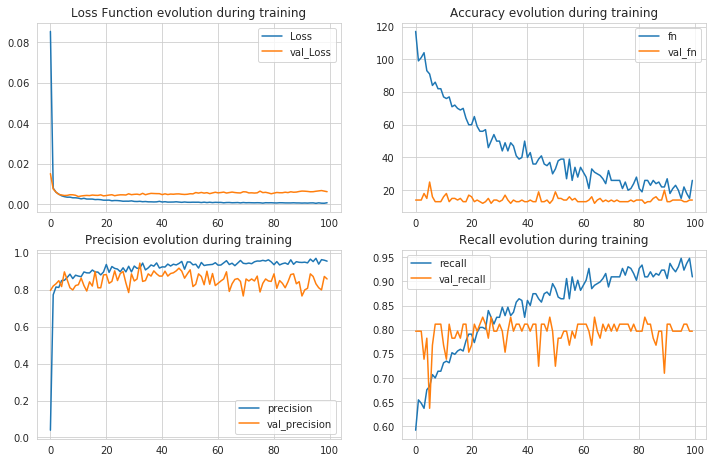

In [28]:
plt.figure(figsize=(12, 16))

plt.subplot(4, 2, 1)
plt.plot(r.history['loss'], label='Loss')
plt.plot(r.history['val_loss'], label='val_Loss')
plt.title('Loss Function evolution during training')
plt.legend()

plt.subplot(4, 2, 2)
plt.plot(r.history['fn'], label='fn')
plt.plot(r.history['val_fn'], label='val_fn')
plt.title('Accuracy evolution during training')
plt.legend()

plt.subplot(4, 2, 3)
plt.plot(r.history['precision'], label='precision')
plt.plot(r.history['val_precision'], label='val_precision')
plt.title('Precision evolution during training')
plt.legend()

plt.subplot(4, 2, 4)
plt.plot(r.history['recall'], label='recall')
plt.plot(r.history['val_recall'], label='val_recall')
plt.title('Recall evolution during training')
plt.legend()

In [29]:
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

print_score(y_train, y_train_pred.round(), train=True)
print_score(y_test, y_test_pred.round(), train=False)

scores_dict = {
    'ANNs': {
        'Train': f1_score(y_train, y_train_pred.round()),
        'Test': f1_score(y_test, y_test_pred.round()),
    },
}

Train Result:
Accuracy Score: 99.99%
_______________________________________________
Classification Report:
                       0           1  accuracy      macro avg  weighted avg
precision       0.999962    0.992933   0.99995       0.996448       0.99995
recall          0.999987    0.979094   0.99995       0.989541       0.99995
f1-score        0.999975    0.985965   0.99995       0.992970       0.99995
support    159204.000000  287.000000   0.99995  159491.000000  159491.00000
_______________________________________________
Confusion Matrix: 
 [[159202      2]
 [     6    281]]

Test Result:
Accuracy Score: 99.95%
_______________________________________________
Classification Report:
                      0           1  accuracy     macro avg  weighted avg
precision      0.999637    0.905172  0.999508      0.952405      0.999486
recall         0.999871    0.772059  0.999508      0.885965      0.999508
f1-score       0.999754    0.833333  0.999508      0.916544      0.999489
suppo

## 6. Extraction of rules, trends or patterns

## 7. Visualization of  rules, trends or patterns

## 9. Optimizing the evaluated model